# Notebook 3 Implementacion Teoria RL Reto: Interlub
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


## Instrucciones:
- Active su entorno de `conda`
- Este Notebook es muy similar al de la actividad 5 del modulo 2
- La idea de este Notebook es que usted ponga en el contexto teorico la solucion del reto Interlub
- El codigo de abajo es la solucion del Notebook 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, chi2, t, kstest, shapiro, f

## 1. Formulación matricial de RLM

Nuestro modelo es

$$y_i=\beta_0+\beta_1x_{i,1}+...+\beta_kx_{i,k}+\epsilon_i$$


Ejercicios:

- Anteriormente, se generaron datos 100% de juguete, el objetivo es adaptar este Notebook para los datos del reto Interlub
- Incluya los datos que genero en las etapas anteriores
- Modifique las lineas de codigo para aumentar el numero de variables explicativas
- Sugerencia: despues de su investigacion de cuales variables son mas importantes en la industria de grasas, enfoquese en alrededor de 5
variables
- Complete las siguientes lineas de codigo siga las instrucciones en los comentarios

In [16]:
df = pd.read_csv('data/datos_grasas_Tec_limpio.csv')  
df.head()

,idDatosGrasas,codigoGrasa,Aceite Base,Espesante,Grado NLGI Consistencia,Viscosidad del Aceite Base a 40°C. cSt,"Penetración de Cono a 25°C, 0.1mm","Punto de Gota, °C","Estabilidad Mecánica, %","Punto de Soldadura Cuatro Bolas, kgf",...,Factor de Velocidad,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max",categoria,subtitulo,descripcion,beneficios,aplicaciones,color,textura
0,1,Grasa_1,Semi-Sintetico,Complejo Sulfonato de Calcio,2.0,680.0,279.0,304,1.07,500.0,...,200000.0,5,220,Grasa,Grasa de servicio pesado para alta resistencia...,El producto es grasa lubricante de servicio pe...,Excelentes caracterÃ­sticas de resistencia al ...,Debido a su composiciÃ³n Ã³ptima de aceites de...,CafÃ©,Suave
1,2,Grasa_2,Mineral HT,Complejo Sulfonato de Calcio,1.5,460.0,300.0,304,2.60,900.0,...,300000.0,-30,150,Grasa,Grasa para lubricaciÃ³n de equipo pesado.,El producto es una grasa lubricante de gran ad...,Extremo soporte de carga.\r\n@Alto contenido d...,LubricaciÃ³n centralizada de equipo pesado.\r\...,Negro,Adherente
2,3,Grasa_3,Mineral HT,Complejo Sulfonato de Calcio,2.0,460.0,280.0,300,10.00,500.0,...,NaN,-10,150,Grasa,Grasa para lubricaciÃ³n de equipo pesado.,El producto es una grasa lubricante de gran ad...,Extremo soporte de carga.\r\n@Alto contenido d...,LubricaciÃ³n centralizada de equipo pesado.\r\...,Negro,Adherente
3,4,Grasa_4,Mineral HT,Complejo Sulfonato de Calcio,2.0,220.0,280.5,300,5.00,500.0,...,NaN,-15,150,Grasa,Grasa lubricante para condiciones extremas.,El producto es una grasa lubricante elaborada ...,Alta estabilidad tÃ©rmica y anti-oxidante.\r\n...,Rodamientos expuestos a alta temperatura y car...,Ambar,Suave
4,5,Grasa_5,Mineral HT,Complejo de Aluminio - Poliurea,1.5,680.0,295.0,260,6.50,620.0,...,NaN,-5,150,Grasa,Grasa lubricante para servicio pesado con alta...,El producto es un grasa lubricante con propied...,Excelente soporte de carga extrema.\r\n@Excele...,El producto es ideal para la lubricaciÃ³n de m...,Negro,Adherente


In [7]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar.chunk(2, dim=-1)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def simular_datos_vae(df_original, n_nuevos=100, latent_dim=5, epochs=500, lr=1e-4):
    """
    documentar
    """
    df_num = df_original.select_dtypes(include=np.number).replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values

    # comentar
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X_norm = (X - mean) / std

    # comentar
    X_tensor = torch.tensor(X_norm, dtype=torch.float32)

    vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
    # comentar
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    def loss_fn(recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x) # comentar
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # comentar
        return recon_loss + kl_loss

    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(X_tensor)
        loss = loss_fn(recon_x, X_tensor, mu, logvar)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            break

    # generacion de datos
    with torch.no_grad():
        z = torch.randn(n_nuevos, latent_dim)
        X_new_norm = vae.decoder(z).numpy()

    # quitar la norm,.
    X_new = X_new_norm * std + mean
    return pd.DataFrame(X_new, columns=df_num.columns)


In [ ]:
"""expanded_data = simular_datos_vae(df, n_nuevos=1000)
data = expanded_data.to_csv('data/datos_grasas_Tec_expandido.csv', index=False)"""

In [2]:
data = pd.read_csv('data/datos_grasas_Tec_expandido.csv')
columnas = ["Viscosidad del Aceite Base a 40°C. cSt",
            "Punto de Gota, °C",
            "Punto de Soldadura Cuatro Bolas, kgf",
            "Desgaste Cuatro Bolas, mm",
            "Temperatura de Servicio °C, min",
            "Temperatura de Servicio °C, max",]

In [3]:
data = data[columnas]

In [4]:
# aqui se empieza el 

# incluya sus datos y sustituya/complete las siguientes lineas
n = len(data)
k = 5
p = k + 1

# valores verdaderos, como modificaria su logica para adptarlo a interlub?
"""beta_0 = 2.5
beta_1 = 1.8
beta_2 = -0.5
beta_3 = 0.3
beta_4 = 0.7
beta_5 = 1.2
beta_6 = -0.8
true_beta = np.array([beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6])"""

y = data["Viscosidad del Aceite Base a 40°C. cSt"].values
X1 = data["Punto de Gota, °C"].values
X2 = data["Punto de Soldadura Cuatro Bolas, kgf"].values
X3 = data["Desgaste Cuatro Bolas, mm"].values
X4 = data["Temperatura de Servicio °C, min"].values
X5 = data["Temperatura de Servicio °C, max"].values

# hacer la matriz X, Para el reto extender esta matriz a cuando menos 5 variables explicativas
X_final = np.column_stack([np.ones(n), X1, X2, X3, X4, X5])

In [5]:
beta_hat = np.linalg.inv(X_final.T @ X_final) @ X_final.T @ y
print("Estimaciones de los coeficientes beta:")
print(beta_hat)
beta0_hat =beta_hat[0]
beta1_hat =beta_hat[1]
beta2_hat =beta_hat[2]
beta3_hat =beta_hat[3]
beta4_hat =beta_hat[4]
beta5_hat =beta_hat[5]

Estimaciones de los coeficientes beta:
[-3.74086841e+03 -1.22695448e+00 -1.29483452e-01  6.98683632e+03
 -2.93292480e+01  7.14875934e+00]


## 2.  Errores

Ejercicios:
- Las lineas de abajo tienen una propuesta poco realista de los errores del model RLM 
- Proponga errores mas realistas para en acorde a grasas encontradas en distintas manufacturas
- Analice el modelo propuesto
- Ejecute las lineas modificadas/aumentadas de codigo

In [6]:
# aqui elija errores 
sigma = 1.5
epsilon = np.random.normal(0, sigma, n)

# RLM matricial
y = X_final @ beta_hat+ epsilon
# print(y)
print(y)


[553.91080407 574.91282985 609.75531923 566.01412247 577.64352258
 602.52943001 594.99374609 566.64695522 571.06525726 605.17799751
 583.67722977 657.77916436 525.66851854 620.67663888 563.05841085
 632.92582557 692.30426269 609.79659992 554.7960385  546.60811459
 583.60482986 565.42599409 564.26702476 587.02037361 601.95952591
 549.48597054 542.96793686 453.09247427 594.66322096 531.71469134
 546.7737461  618.57151831 563.9732148  524.07548037 528.36541553
 636.47363324 566.43814921 573.72749425 543.83674551 604.17810685
 606.45255334 601.67507168 601.1824288  557.24680059 598.04447945
 558.31600869 583.59440574 546.81039208 586.49468504 694.08595593
 513.25524986 549.76056901 622.27089341 607.97580253 536.89635703
 655.69207525 515.22839743 662.65931669 607.0335863  596.08351947
 494.41113355 604.28748291 599.74184332 655.52382786 600.80211259
 566.10792262 586.9316497  568.32823983 557.64684807 611.09728757
 616.79112946 609.5515264  655.77280203 586.62402487 632.49904654
 595.74417

## 3. Propiedades de la matriz sombrero $\hat{H}$

Ejercicios:
- Analice si la nueva matriz sombrero cumple con las propiedades utiles
- En caso de no cumplir con las propiedades, investigue el motivo y subsane para que lo sea

In [7]:
# construya la matriz X^T X
X_transpose_X = X_final.T @ X_final
print(f"\nX'X matrix ({p} × {p}):")
print(X_transpose_X)

# primero verificar si X^T X es invertible con el rango
rank = np.linalg.matrix_rank(X_transpose_X)
print(f"\nRango of X'X: {rank}/{p}")
print(f"X'X es invertible: {rank == p}")


X'X matrix (6 × 6):
[[ 1.00000000e+03  2.71101493e+05  4.85695451e+05  4.75525780e+02
  -1.03492829e+04  1.54122773e+05]
 [ 2.71101493e+05  7.35467092e+07  1.31793559e+08  1.28897263e+05
  -2.80516254e+06  4.17925497e+07]
 [ 4.85695451e+05  1.31793559e+08  2.37278272e+08  2.30985214e+05
  -5.03719445e+06  7.48770322e+07]
 [ 4.75525780e+02  1.28897263e+05  2.30985214e+05  2.26148350e+02
  -4.92329043e+03  7.32805799e+04]
 [-1.03492829e+04 -2.80516254e+06 -5.03719445e+06 -4.92329043e+03
   1.07746134e+05 -1.59398038e+06]
 [ 1.54122773e+05  4.17925497e+07  7.48770322e+07  7.32805799e+04
  -1.59398038e+06  2.37648108e+07]]

Rango of X'X: 6/6
X'X es invertible: True


## 4. Estimador de $y (\hat{y})$

Ejercicios:
- Estime y con las lineas de abajo
- Analice y valide en el contexto de grasas si sus resultados van acorde a lo esperado


In [8]:
# ahora encuentre la inversa de X^T X
X_transpose_X_inv = np.linalg.inv(X_transpose_X)

# encuentra beta vector estimador
beta_hat = X_transpose_X_inv @ X_final.T @ y
#print(f"True β: {true_beta}")
print(f"OLS β_hat: {beta_hat}")

# encuentre la matriz de covarianza de los estimadores
cov_beta_hat = (sigma ** 2) * X_transpose_X_inv
print(f"\nTheoretical Cov(β_hat):")
print(cov_beta_hat)

# encuentre los errores estandar de las b0, b1,b2... extienda hasta donde usted decido anteriormente
std_errors = np.sqrt(np.diag(cov_beta_hat))
print(f"\nTheoretical Standard Errors:")
print(f"SE(β₀): {std_errors[0]:.4f}")
print(f"SE(β₁): {std_errors[1]:.4f}")
print(f"SE(β₂): {std_errors[2]:.4f}")
print(f"SE(β₃): {std_errors[3]:.4f}")
print(f"SE(β₄): {std_errors[4]:.4f}")
print(f"SE(β₅): {std_errors[5]:.4f}")

# encuentre el estimador de y
y_hat = X_final@X_transpose_X_inv @ X_final.T @ y


OLS β_hat: [-3.73960940e+03 -1.20920894e+00 -1.30594709e-01  6.98715460e+03
 -2.93264803e+01  7.11149086e+00]

Theoretical Cov(β_hat):
[[ 1.01502062e+02 -6.83313283e-02  9.18777048e-03 -1.50309521e+02
  -3.08651021e-02 -1.05636071e-01]
 [-6.83313283e-02  1.03752066e-04 -1.06833646e-05  9.49541439e-02
   1.81651371e-05  2.77507799e-06]
 [ 9.18777048e-03 -1.06833646e-05  3.29157912e-06 -1.20982801e-02
   4.52717409e-05 -1.08265978e-05]
 [-1.50309521e+02  9.49541439e-02 -1.20982801e-02  2.45647096e+02
   2.82935437e-01  1.07447084e-01]
 [-3.08651021e-02  1.81651371e-05  4.52717409e-05  2.82935437e-01
   5.88407782e-03 -4.52203648e-04]
 [-1.05636071e-01  2.77507799e-06 -1.08265978e-05  1.07447084e-01
  -4.52203648e-04  3.52759881e-04]]

Theoretical Standard Errors:
SE(β₀): 10.0748
SE(β₁): 0.0102
SE(β₂): 0.0018
SE(β₃): 15.6731
SE(β₄): 0.0767
SE(β₅): 0.0188


## 5. Interpretacion de los errores

Ejercicios:
- Esta parte es fundamental ya que vamos a poder dar una nocion de que tan buen es el modelo de RLM para atacar problemas del  mundo real
- Lo principal es encontrar una tabla de errores como la estudiada en modulo 2
- Describa de manera cuantitaiva y cualitativa los errores en RLM para el caso de reto Interlub

In [9]:
# encuentre el MSE de y_hat y y medida
mse_rlm = np.sum((y_hat-y)**2)/len(y)
print(mse_rlm, "check mse")

# encuentre los elementos de la tabla de varianzas
# es decir, encuentre SSR, SSE y Syy
SSR = np.sum((y_hat - np.mean(y))**2)
SSE = np.sum((y - y_hat)**2)
Syy = np.sum((y - np.mean(y))**2)
print(f"\nSSR: {SSR:.4f}")
print(f"SSE: {SSE:.4f}")
print(f"Syy: {Syy:.4f}")
# enuncie una explicación integral de cada termino

2.3864182009844437 check mse

SSR: 1885937.7281
SSE: 2386.4182
Syy: 1888324.1462


## 6. Graficas


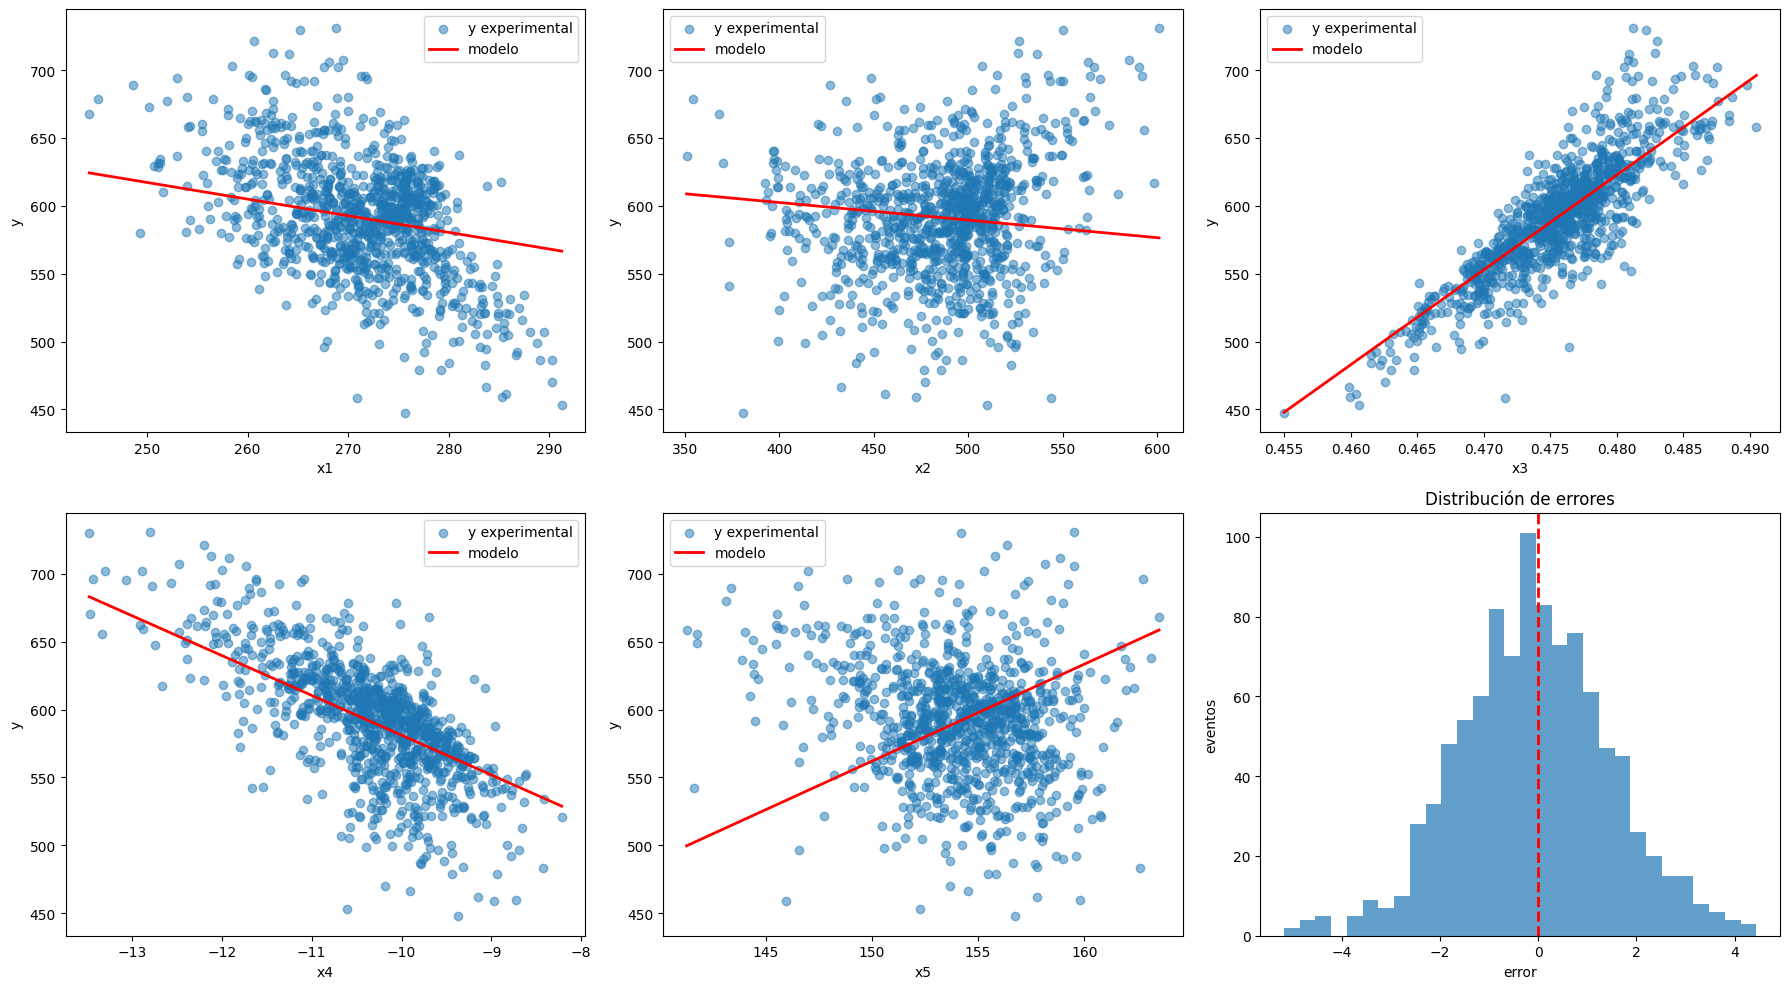

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5, ax_err = axes.ravel()

# x1
x1_grid = np.linspace(X1.min(), X1.max(), 100)
line_x1 = beta0_hat + beta1_hat * x1_grid + beta2_hat * np.mean(X2) + beta3_hat * np.mean(X3) + beta4_hat * np.mean(X4) + beta5_hat * np.mean(X5)
ax1.scatter(X1, y, alpha=0.5, label='y experimental')
ax1.plot(x1_grid, line_x1, 'r-', linewidth=2, label='modelo')
ax1.set_xlabel('x1')
ax1.set_ylabel('y')
ax1.legend()

# x2
x2_grid = np.linspace(X2.min(), X2.max(), 100)
line_x2 = beta0_hat + beta1_hat * np.mean(X1) + beta2_hat * x2_grid + beta3_hat * np.mean(X3) + beta4_hat * np.mean(X4) + beta5_hat * np.mean(X5)
ax2.scatter(X2, y, alpha=0.5, label='y experimental')
ax2.plot(x2_grid, line_x2, 'r-', linewidth=2, label='modelo')
ax2.set_xlabel('x2')
ax2.set_ylabel('y')
ax2.legend()

# x3
x3_grid = np.linspace(X3.min(), X3.max(), 100)
line_x3 = beta0_hat + beta1_hat * np.mean(X1) + beta2_hat * np.mean(X2) + beta3_hat * x3_grid + beta4_hat * np.mean(X4) + beta5_hat * np.mean(X5)
ax3.scatter(X3, y, alpha=0.5, label='y experimental')
ax3.plot(x3_grid, line_x3, 'r-', linewidth=2, label='modelo')
ax3.set_xlabel('x3')
ax3.set_ylabel('y')
ax3.legend()

# x4
x4_grid = np.linspace(X4.min(), X4.max(), 100)
line_x4 = beta0_hat + beta1_hat * np.mean(X1) + beta2_hat * np.mean(X2) + beta3_hat * np.mean(X3) + beta4_hat * x4_grid + beta5_hat * np.mean(X5)
ax4.scatter(X4, y, alpha=0.5, label='y experimental')
ax4.plot(x4_grid, line_x4, 'r-', linewidth=2, label='modelo')
ax4.set_xlabel('x4')
ax4.set_ylabel('y')
ax4.legend()

# x5
x5_grid = np.linspace(X5.min(), X5.max(), 100)
line_x5 = beta0_hat + beta1_hat * np.mean(X1) + beta2_hat * np.mean(X2) + beta3_hat * np.mean(X3) + beta4_hat * np.mean(X4) + beta5_hat * x5_grid
ax5.scatter(X5, y, alpha=0.5, label='y experimental')
ax5.plot(x5_grid, line_x5, 'r-', linewidth=2, label='modelo')
ax5.set_xlabel('x5')
ax5.set_ylabel('y')
ax5.legend()

# Histograma de errores
ax_err.hist(epsilon, bins=30, alpha=0.7)
ax_err.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax_err.set_xlabel('error')
ax_err.set_ylabel('eventos')
ax_err.set_title('Distribución de errores')

plt.tight_layout()
plt.show()
fig.clf()


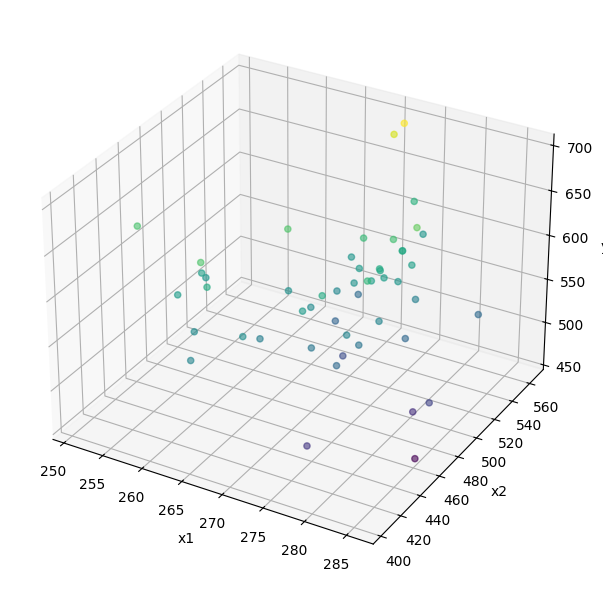

In [12]:
from mpl_toolkits.mplot3d import Axes3D  # opcional en versiones nuevas de mpl

fig = plt.figure(figsize=(6, 6))
ax_3d = fig.add_subplot(111, projection='3d')

subset = np.arange(0, n, 20)  # cada 20 puntos

scatter = ax_3d.scatter(
    X1[subset],
    X2[subset],
    y[subset],
    c=y[subset],
    cmap='viridis',
    alpha=0.6
)

ax_3d.set_xlabel('x1')
ax_3d.set_ylabel('x2')
ax_3d.set_zlabel('y')

plt.tight_layout()
plt.show()


## 7. F-estadistica de RLM

Ejercicios:
- Complete las siguientes "leads" de código
- Adapte el codigo para dar solucion al reto Interlub

In [18]:
# aqui se empieza el código

# dada la matriz X de la seccion anterior
# muestre que I - X(X'X)-1 X' es idempotente
matriz = np.eye(n) - X_final @ X_transpose_X_inv @ X_final.T
result = matriz @ matriz
if np.allclose(result, matriz):
    result = "I - X(X'X)^-1 X' es idempotente"
else:
    result = "I - X(X'X)^-1 X' no es idempotente"
print(result)


# encuentre el rango I - X(X'X)-1 X'
# [Sugerencia: rango = np.linalg.matrix_rank()]
rango = np.linalg.matrix_rank(matriz)
print(rango)

# muestre que X(X'X)-1 X' es idempotente
matriz2 = X_final @ X_transpose_X_inv @ X_final.T
result = matriz2 @ matriz2
if np.allclose(result, matriz2):
    result = "X(X'X)^-1 X' es idempotente"
else:
    result = "X(X'X)^-1 X' no es idempotente"
print(result)

# encuentre el rango de X(X'X)-1 X'
# [Sugerencia: rango = np.linalg.matrix_rank()]
rango = np.linalg.matrix_rank(matriz2)
print(rango)


# muestre que (I - X(X'X)-1 X')*(X(X'X)-1 X) = 0
producto = matriz @ matriz2
if np.allclose(producto, np.zeros((n, n))):
    result = "(I - X(X'X)^-1 X')*(X(X'X)^-1 X) = 0 se cumple"
else:
    result = "(I - X(X'X)^-1 X')*(X(X'X)^-1 X) = 0 no se cumple"
print(result)
# cuales son las consecuencias de esto


# ahora usando la y vector de la seccion anterior
# y las betas y sus estimadores
# encuentre la estadística lambda (resultado del Lemma de Neyman-Pearson)
"""lambda_stat = np.exp(-0.5 / sigma**2 * ((y - y_hat).T @ (y - y_hat)))
print(f"\nNeyman-Pearson λ statistic: {lambda_stat:.6f}")"""

SSE = float((y - y_hat).T @ (y - y_hat))             # error del modelo completo
SST = float(((y - y.mean())**2).sum())   
sigma2 = sigma**2
lambda_stat = np.exp(-0.5 / sigma2 * (SST - SSE))
print(f"\nNeyman-Pearson λ statistic: {lambda_stat:.6f}")

I - X(X'X)^-1 X' es idempotente
998
X(X'X)^-1 X' es idempotente
6
(I - X(X'X)^-1 X')*(X(X'X)^-1 X) = 0 se cumple

Neyman-Pearson λ statistic: 0.000000


## 8. Investigacion mas alla del Notebook

Ejercicios:
- Aumente la forma en que puede caracterizar los resultados de RLM
- Que otras metricas podrian ser utiles? Incluyalas!
- Busque otros modelos que puedan superar al RLM
- Use su imaginacion para hacer la solucion de reto mejor

El modelo RLM puede caracterizarse mejor analizando la significancia estadística de los coeficientes, sus intervalos de confianza y la presencia de multicolinealidad mediante VIF. También es útil revisar los residuos para verificar normalidad, homocedasticidad y ausencia de puntos influyentes. Esto permite evaluar si el modelo cumple los supuestos y si las relaciones estimadas son confiables.

Además del MSE y ${R^2}$, métricas como MAE, RMSE y MAPE permiten evaluar el error desde distintas perspectivas. AIC y BIC ayudan a comparar modelos penalizando la complejidad. Incluir varias métricas ofrece una evaluación más robusta del desempeño del modelo.

Modelos como Random Forest, XGBoost y SVR suelen mejorar la precisión cuando la relación entre variables no es lineal. Estos algoritmos capturan patrones complejos que el RLM no puede representar. Por eso pueden ofrecer mejor desempeño en datos reales o con interacciones fuertes.

Se puede mejorar la solución añadiendo un análisis de sensibilidad que muestre cómo cambian las predicciones al modificar manualmente variables clave. También puede integrarse validación cruzada y selección automática de variables para obtener un modelo más estable. Finalmente, métodos como SHAP ayudan a explicar por qué el modelo recomienda ciertos valores, aumentando interpretabilidad.